In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys

In [2]:
df_piplus = pd.read_csv('/disk/lhcb_data/davide/HCAL_project_full_event/csv/piplus/MCtrue_piplus.csv', index_col=False)
df_piplus0 = pd.read_csv('/disk/lhcb_data/davide/HCAL_project_full_event/csv/piplus0/MCtrue_piplus0.csv', index_col=False)
df_Kminus = pd.read_csv('/disk/lhcb_data/davide/HCAL_project_full_event/csv/Kminus/MCtrue_Kminus.csv', index_col=False)




In [3]:
true_events_piplus=df_piplus.to_dict(orient='list')
true_events_piplus0=df_piplus0.to_dict(orient='list')
true_events_Kminus=df_Kminus.to_dict(orient='list')

for key in true_events_piplus:
    true_events_piplus[key]=np.array(true_events_piplus[key])
    true_events_piplus0[key]=np.array(true_events_piplus0[key])
    true_events_Kminus[key]=np.array(true_events_Kminus[key])

In [4]:
#DETERMINE MAX AND MIN X,Y
max_X=np.max(true_events_piplus['true_x'][np.where(true_events_piplus['region']>=0)])
min_X=np.min(true_events_piplus['true_x'][np.where(true_events_piplus['region']>=0)])

#width_X=np.ceil(max_X-min_X)
width_X=8403.0

max_Y=np.max(true_events_piplus['true_y'][np.where(true_events_piplus['region']>=0)])
min_Y=np.min(true_events_piplus['true_y'][np.where(true_events_piplus['region']>=0)])

#width_Y = np.ceil(max_Y-min_Y)
width_Y=6812.0

In [5]:
#number of events
batch_size=25000

n_batches=2
save_test_images = False

In [6]:
piplus = np.array([{} for i in range(n_batches)])
piplus0 = np.array([{} for i in range(n_batches)])
Kminus = np.array([{} for i in range(n_batches)])

for i in range(n_batches):
    
    for key in true_events_piplus:
        piplus[i][key]= true_events_piplus[key][i*batch_size:(i+1)*batch_size]
    for key in true_events_piplus0:
        piplus0[i][key]= true_events_piplus0[key][i*batch_size:(i+1)*batch_size]
    for key in true_events_Kminus:
        Kminus[i][key]= true_events_Kminus[key][i*batch_size:(i+1)*batch_size]
    

In [7]:
#reconverting to np.arrays
def create_grid_and_normalise(particle, X_pixels=64, width_X=width_X, width_Y=width_Y):
    
    particle_norm=np.array([{} for i in range(n_batches)])

    for i in range(n_batches):
        particle_norm[i]["true_x"]=particle[i]["true_x"]/(width_X/2)
        particle_norm[i]["true_y"]=particle[i]["true_y"]/(width_Y/2)
    
        particle_norm[i]["true_ET"]=particle[i]["true_ET"]
        particle_norm[i]["region"]=particle[i]["region"]
 #   for i in range(n_batches):
 #       for j in range(particle[i]["region"].shape[0]):
 #           if particle[i]["region"][j]>=0:
                
    Y_pixels=np.int(np.floor((X_pixels*width_Y)/width_X))

    x_values = np.linspace(-X_pixels//2-1,np.ceil(X_pixels/2)+1,X_pixels+3)
    y_values = np.linspace(-Y_pixels//2-1,np.ceil(Y_pixels/2)+1,Y_pixels+3)

    X_grid, Y_grid = np.meshgrid(x_values, y_values)
    
    return X_grid, Y_grid, particle_norm

In [8]:
X_grid, Y_grid, piplus_norm = create_grid_and_normalise(piplus)
_, _,  piplus0_norm= create_grid_and_normalise(piplus0)
_, _, Kminus_norm = create_grid_and_normalise(Kminus)

In [9]:
X_pixels = 64
Y_pixels = np.int(np.ceil((X_pixels*width_Y)/width_X))
Y_pixels

52

In [10]:
def make_pics_dict(X_grid, Y_grid, particle, n_batches=n_batches):
    
    pic = np.zeros(shape=(Y_pixels,X_pixels,1),dtype=np.float32)
    pics_dict = {}
        
    for n in range(n_batches):
        
        batch_size = particle[n]["region"].shape[0]
        pics_dict[n]=np.array([pic for i in range(0,batch_size)])
        
        for k in range(batch_size):
            event=k
            if particle[n]["region"][event]>=0: #and particle_1[n]["region"][event]>=0 and particle_2[n]["region"][event]>=0:
                #event = n*batch_size+k
                
                #print(event)
                for i in range(X_grid.shape[0]):
                    for j in range(Y_grid.shape[1]):
                                
                        if X_grid[i,j] < particle[n]["true_x"][event]*X_pixels/2 < X_grid[i,j+1]:
                            if Y_grid[i,j] < particle[n]["true_x"][event]*Y_pixels/2 < Y_grid[i+1,j]:
                                
                                x_primed=int(Y_pixels/2-Y_grid[i,j])
                                y_primed=int(X_pixels/2+X_grid[i,j])
                                
                                #pics_dict[n][k][x_primed,y_primed,0]=1
    
                                pics_dict[n][k][x_primed-1,y_primed-1,0]=particle[n]["true_ET"][event]
                                #total_pic[x_primed-1,y_primed-1,0]=1
                                #total_pic[x_primed-1,y_primed-1,0]=true_events['true_ET'][event]
    
                            
        print('Converted '+str(n+1)+'/'+str(n_batches)+' batches of ' +str(batch_size)+' images')
    
  #  
  #  if N % batch_size != 0:
  #      
  #      print('Converting last batch of '+str(N%batch_size)+' images') 
  #  
  #      for k in range(batch_size*n_batches,N):
  #          #if true_events['region'][k]>=0:
  #  
  #              for i in range(X_grid.shape[0]):
  #                  for j in range(Y_grid.shape[1]):
  #                      if X_grid[i,j-1] < X_norm[n_batches][k]*X_pixels/2 < X_grid[i,j]:
  #                          if Y_grid[i-1,j] < Y_norm[n_batches][k]*Y_pixels/2 < Y_grid[i,j]:
  #                              
  #                              x_primed=int(Y_pixels/2-Y_grid[i,j])
  #                              y_primed=int(X_pixels/2+X_grid[i,j])
  #                              
  #                              pics_dict[n_batches][k-(N-1)][x_primed,y_primed,0]=true_events['true_ET'][event]
  #                              #total_pic[x_primed,y_primed,0]=true_events['true_ET'][event]
    return pics_dict

In [14]:
pics_dict_piplus = make_pics_dict(X_grid, Y_grid, piplus_norm, n_batches)

Converted 1/2 batches of 25000 images
Converted 2/2 batches of 25000 images


In [15]:
pics_dict_piplus0 = make_pics_dict(X_grid, Y_grid, piplus0_norm, n_batches)

Converted 1/2 batches of 25000 images
Converted 2/2 batches of 25000 images


In [16]:
pics_dict_Kminus = make_pics_dict(X_grid, Y_grid, Kminus_norm, n_batches)

Converted 1/2 batches of 25000 images
Converted 2/2 batches of 25000 images


In [18]:
pics_dict_piplus[1].shape

(25000, 52, 64, 1)

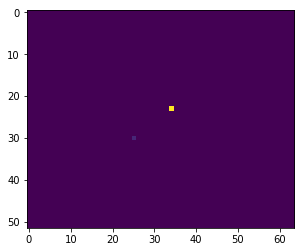

In [20]:
i=1
plt.imshow(pics_dict_piplus[1][i].reshape(52,64)+pics_dict_piplus0[1][i].reshape(52,64)+pics_dict_Kminus[0][i].reshape(52,64))


In [23]:
pics_dict={}

pics_dict[0]=pics_dict_piplus[0]+pics_dict_piplus0[0]+pics_dict_Kminus[0]
pics_dict[1]=pics_dict_piplus[1]+pics_dict_piplus0[1]+pics_dict_Kminus[1]

In [24]:
for i in range(n_batches):
    with open('/disk/lhcb_data/davide/HCAL_project_full_event/true/sample'+str(i)+'.pickle', 'wb') as handle:
        pickle.dump(pics_dict[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
a=np.array([pics_dict_Kminus[0][i].sum()+pics_dict_piplus[0][i].sum()+pics_dict_piplus0[0][i].sum() for i in range(len(pics_dict_Kminus[0]))])

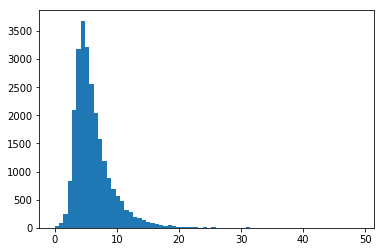

In [31]:
plt.hist(a/1000,bins=70);

NameError: name 'r' is not defined